In [319]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import sweetviz as sv

In [320]:
_Xtrain = pd.read_csv("x_train.csv", index_col='ID')
_y = pd.read_csv("y_train.csv", index_col='ID')
train = pd.concat([_Xtrain, _y], axis=1)
test = pd.read_csv('x_test.csv', index_col='ID')

In [301]:
to_drop = [f'RET_{day}' for day in range(6,21)]
to_drop += [f'VOLUME_{day}' for day in range(6,21)]
cleaned_train = train.drop(columns= to_drop)

# EDA with original features

The dataset is made of 46 descriptive features: (all float / int values)

* DATE: an index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates),
* STOCK: an index of the stock,
* INDUSTRY: an index of the stock industry domain (e.g., aeronautic, IT, oil company),
* INDUSTRY_GROUP: an index of the group industry,
* SUB_INDUSTRY: a lower level index of the industry,
* SECTOR: an index of the work sector,
* RET_1 to RET_20: the historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on),
* VOLUME_1 to VOLUME_20: the historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on),

And 1 target variable: (binary)
* RET: the sign of the residual stock return at time t

## NaN values


There are quite a few NaN values especially in the volume columns. With up to almost 20% of NaN values in the Volume columns these are non negligible and can't be dropped. Thus, we have to find a way to impute them. 

Why are so many NaN values in the Volume? The relative volumes are computed using the median and the way the median function is implemented in python could cause the NaN values: if we compute the relative volume over a period of 10 days and there is one NaN value at day D, the relative volume will show NaN values from day D to day D+10.

The NaN values in the RET columns can come from the nature of the stock market data: The market closes on some days (weekends, public holidays, etc.). This could also apply to the relative volume and contribute to the NaN values.

In [76]:
(cleaned_train.isna().sum()/len(cleaned_train)*100)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.563552
VOLUME_1          15.534108
RET_2              0.588875
VOLUME_2          15.859243
RET_3              0.598908
VOLUME_3          16.201579
RET_4              0.607747
VOLUME_4          16.960785
RET_5              0.617303
VOLUME_5          17.843739
RET                0.000000
dtype: float64

Lets have a look at how the NaN values propagate through the categories and sub-categories

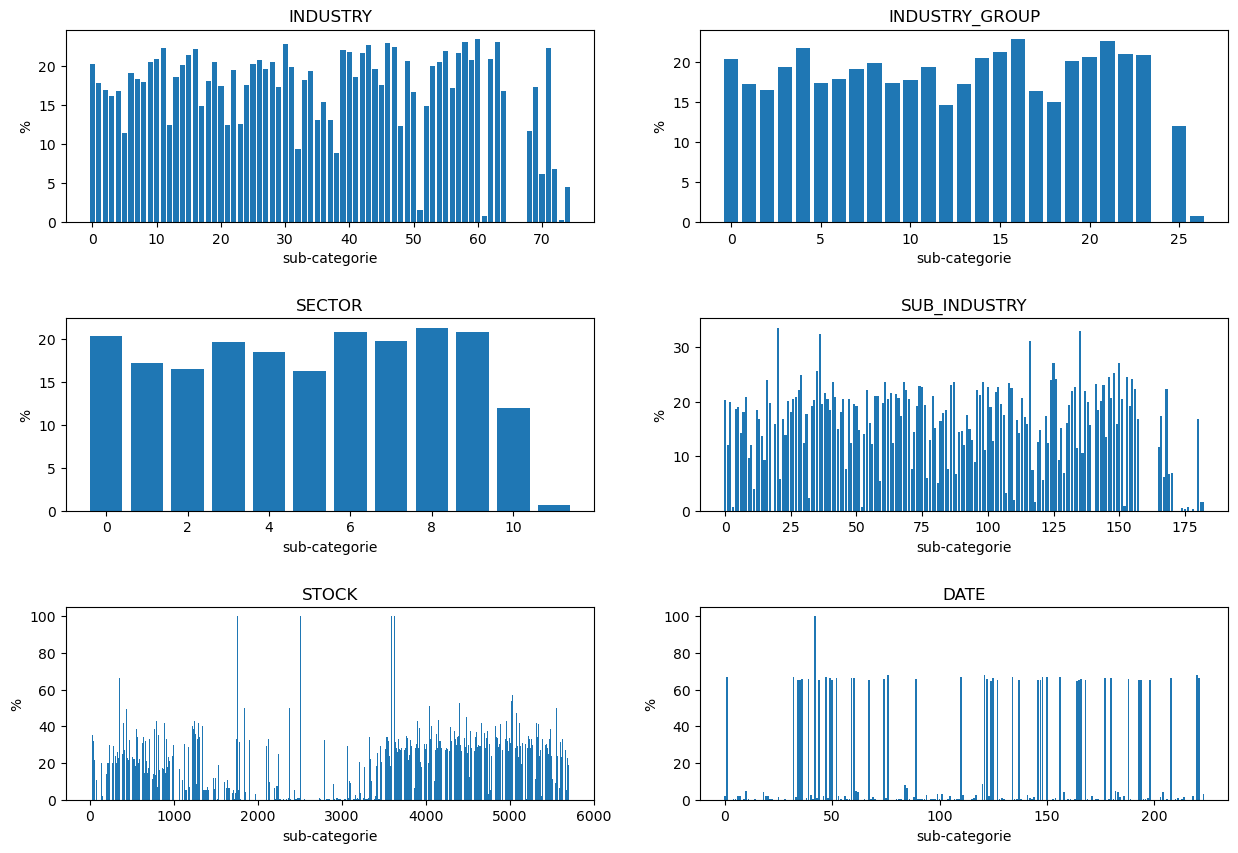

In [5]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(hspace=0.5)
for i,categorie in enumerate(['INDUSTRY', 'INDUSTRY_GROUP', 'SECTOR', 'SUB_INDUSTRY', 'STOCK', 'DATE']): 
    plt.subplot(3,2,i+1)
    plt.title(categorie)
    plt.bar(cleaned_train[categorie].sort_values().unique(),
            [(cleaned_train[cleaned_train[categorie]==sub_categorie].isna().sum(axis=1)>0).sum()/len(cleaned_train[cleaned_train[categorie]==sub_categorie])*100 for sub_categorie in cleaned_train[categorie].sort_values().unique()])
    plt.xlabel('sub-categorie')
    plt.ylabel('%')
plt.show()
        

The plots show the % of NaN values per sub-categorie where at least one value was missing. We can see a fairly even distribution of NaN values for the categorical variable sector, whereas the amount of NaN values for the other categorical variables seems less equally spread. It might be interesting to see if there are rows that predominantely consist of NaN values (for the descriptive variables RET and VOLUME).

Given that there are no observed Returns, there are also no Volumes observed. Given that no Volumes occur far more often than no returns, we only focus on them. We only delete those where that have no Return observed for the past 5 days, since we only use them in our analysis.

In [77]:
# Check if there exist a row containing mainly NaN values
ret_features = [f'RET_{day}' for day in range(1,6)]
#features += [f'VOLUME_{day}' for day in range(1,21)] # No need to consider VOLUME since it either is there or not
ret_to_drop = cleaned_train[(cleaned_train[ret_features].isna().sum(axis=1)/(cleaned_train[ret_features].shape[1]) >= 1)][ret_features]
ret_to_drop

,RET_1,RET_2,RET_3,RET_4,RET_5
ID,,,,,
2237,NaN,NaN,NaN,NaN,NaN
19916,NaN,NaN,NaN,NaN,NaN
20232,NaN,NaN,NaN,NaN,NaN
27739,NaN,NaN,NaN,NaN,NaN
28578,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
401583,NaN,NaN,NaN,NaN,NaN
401584,NaN,NaN,NaN,NaN,NaN
401585,NaN,NaN,NaN,NaN,NaN


We see that there are 2241 rows that do not provide any value to our data, i.e. 2256 rows contain only NaN values for the RET and VOLUME. Therefore, we are going to drop them, as they only add noise. It could be interesting to understand the behavior when we increase the threshold of observed values. In particular, by deleting all rows where for the past 5 days no return has been observed, we delete all rows that have not observed return over all (since we have a subset) 

We quickly check if there is a possiblity to observe volume given no return record for the past 5 days. 

In [78]:
cleaned_train.iloc[ret_to_drop.index][[f'VOLUME_{day}' for day in range(1,6)]].isna().sum(axis=1).min()

5

We now drop the corresponding rows

In [79]:
cleaned_train.drop(index=ret_to_drop.index, inplace=True)

In [80]:
(cleaned_train.isna().sum()/len(cleaned_train)*100)

DATE               0.000000
STOCK              0.000000
INDUSTRY           0.000000
INDUSTRY_GROUP     0.000000
SECTOR             0.000000
SUB_INDUSTRY       0.000000
RET_1              0.024739
VOLUME_1          15.076416
RET_2              0.050199
VOLUME_2          15.403313
RET_3              0.060287
VOLUME_3          15.747504
RET_4              0.069174
VOLUME_4          16.510824
RET_5              0.078782
VOLUME_5          17.398562
RET                0.000000
dtype: float64

We see that we were able to reduce the number of missing values in the return columns very well. Howeer, there is still a significant portion of unobserved values in the volume columns. We will now investigate those.

In [81]:
volume = pd.DataFrame(columns=['day', 'ret_mean', 'ret_median', 'ret_std', 'vol_mean', 'vol_median', 'vol_std'])
for day in range(1,6):
    volume.loc[day] =[day, cleaned_train[f'RET_{day}'].mean(), cleaned_train[f'RET_{day}'].median(), cleaned_train[f'RET_{day}'].std(), 
                      cleaned_train[f'VOLUME_{day}'].mean(), cleaned_train[f'VOLUME_{day}'].median(), cleaned_train[f'VOLUME_{day}'].std()]

volume


,day,ret_mean,ret_median,ret_std,vol_mean,vol_median,vol_std
1,1.0,0.001383,0.000637,0.031311,-0.071502,-0.282609,3.038658
2,2.0,0.000973,0.000401,0.030987,-0.075230,-0.278437,2.635549
3,3.0,0.002153,0.000909,0.031332,-0.097235,-0.278277,2.490831
4,4.0,-0.000679,-0.000495,0.031224,-0.088976,-0.275435,1.730786
5,5.0,0.000358,0.000000,0.031886,-0.092163,-0.281238,1.848977


We see that the mean of the relative volume for each trading day is approx. 0 and the standard-deviation is also fairly negligeble. Therefore, we areg oing to impute missing values with its mean. Since there are almost no missing values for the returns, we are going to mean impute them as well. It would be interesting to see how well we perform, if we use the median for the volume. The median makes more sense compared to the mean. For this we could look at boxplots.

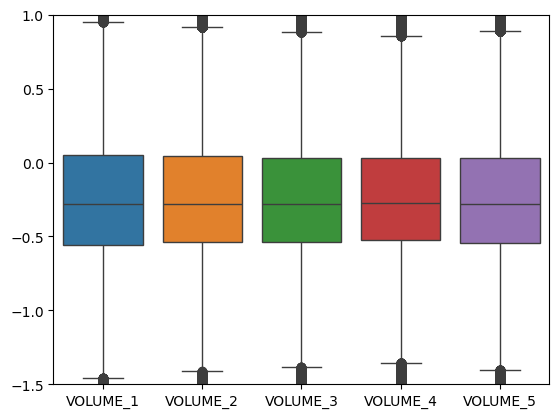

In [11]:
sns.boxplot(cleaned_train[[f'VOLUME_{day}' for day in range(1,6)]])
plt.ylim((-1.5,1))
plt.show()

From the boxplots it becomes obvious that a median imputation for missing values in the colums is the better choice.

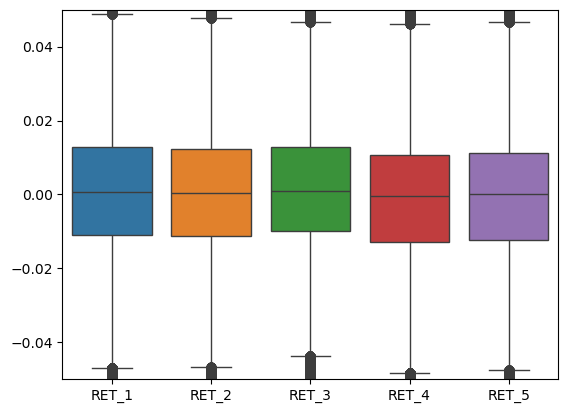

In [13]:
sns.boxplot(cleaned_train[[f'RET_{day}' for day in range(1,6)]])
plt.ylim((-0.05,0.05))
plt.show()

We see that the median is almost identical to the mean and median almost coincide, therefore, we go here with the median as well.  

## Dataset balance

We now look at how balanced the data is.

In [113]:
train['RET'].value_counts(normalize=True)*100

RET
False    50.107861
True     49.892139
Name: proportion, dtype: float64

We see that the dataset seems pretty balanced. We can therefore afford to use a conventional approach to the problem, putting inbalance-related issues aside.

## Correlation

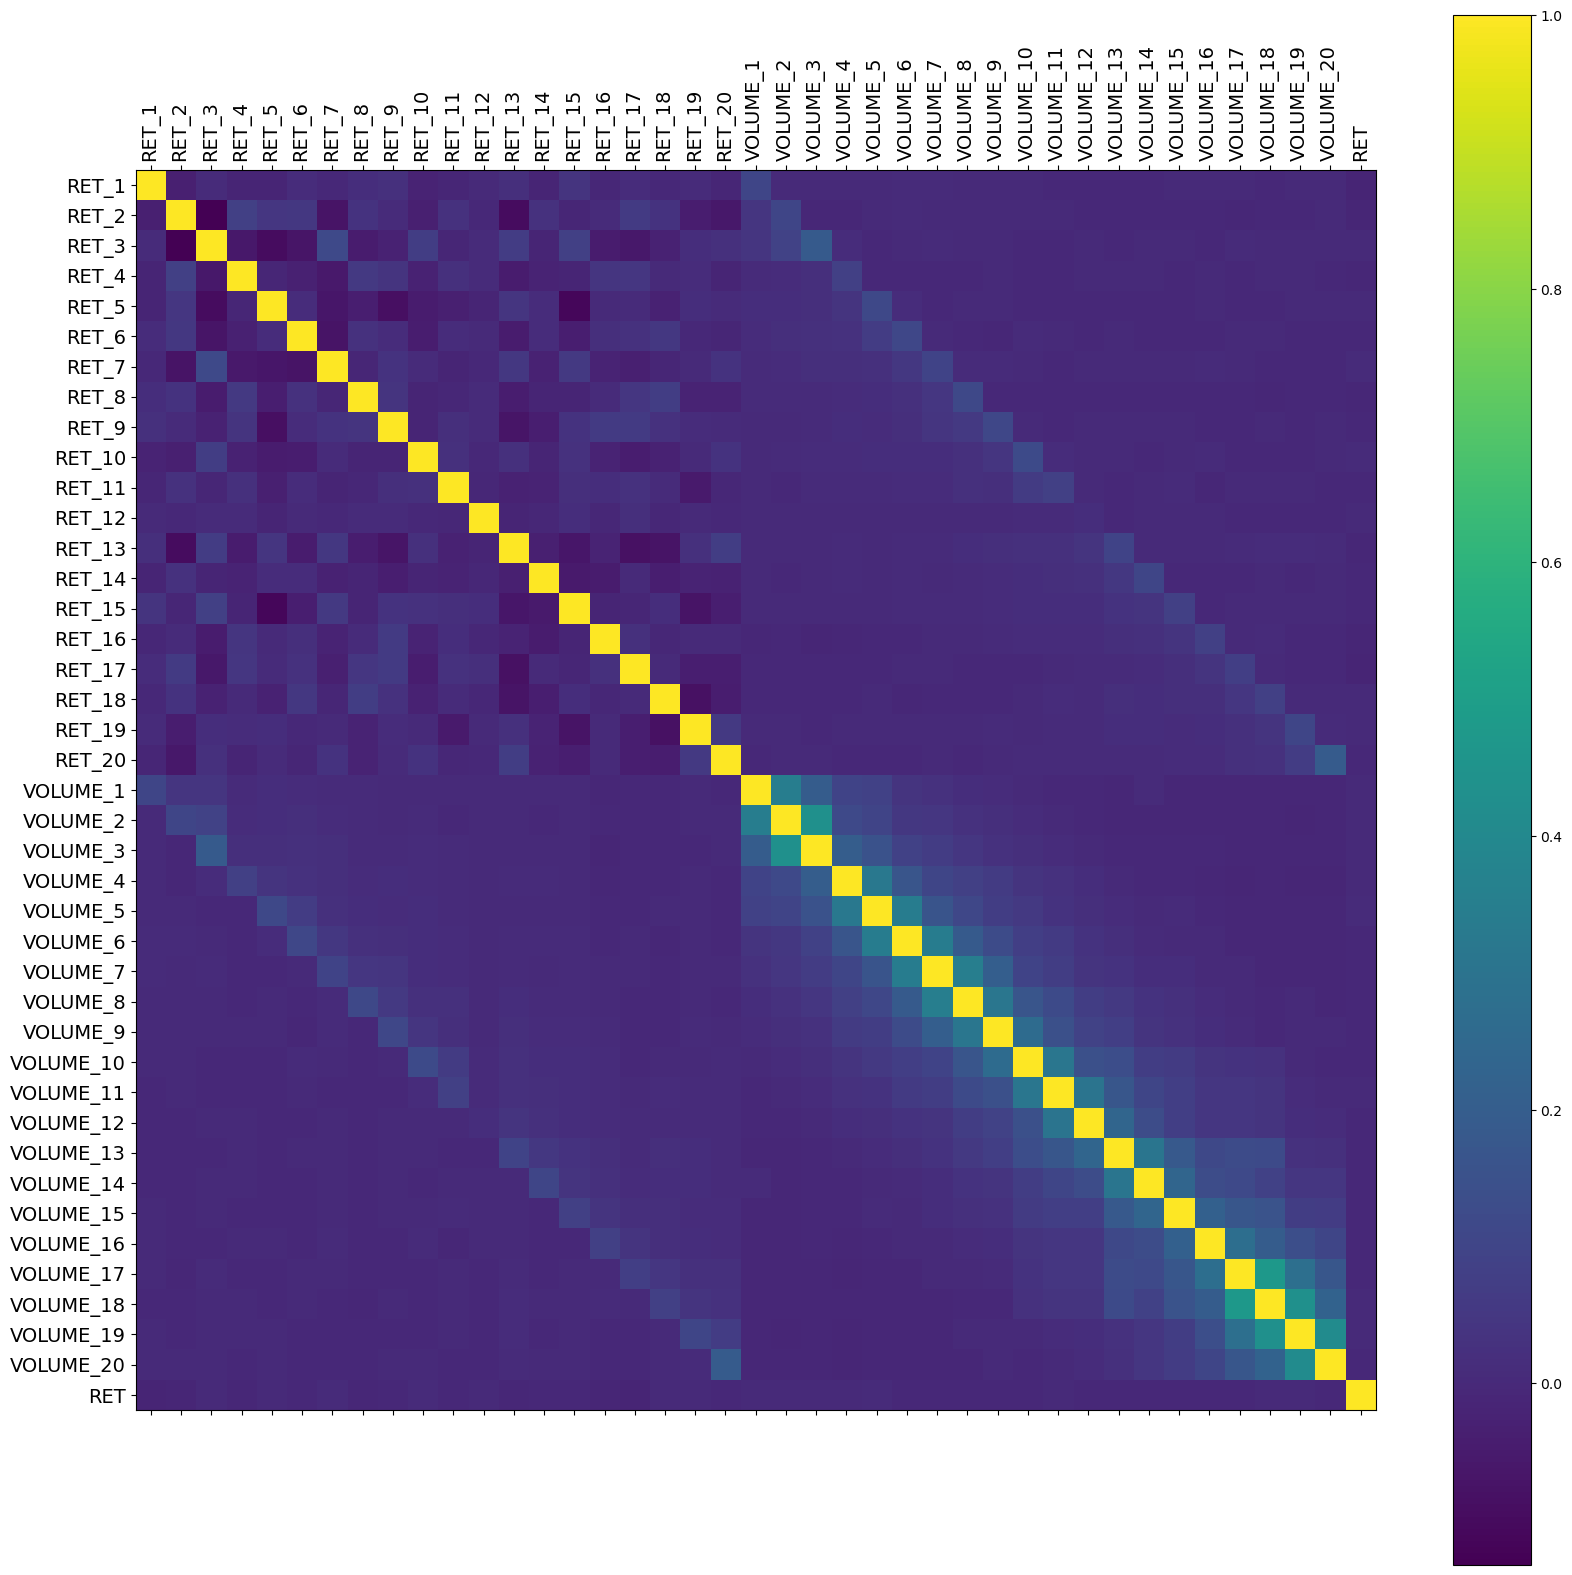

In [123]:
features = [f'RET_{day}' for day in range(1,21)]
features += [f'VOLUME_{day}' for day in range(1,21)]
features += ['RET']

fig = plt.figure(figsize=(20,20))
plt.matshow(train[features].corr(), fignum=fig.number)
plt.xticks(range(train[features].shape[1]), train[features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[features].shape[1]), train[features].columns, fontsize=14)
plt.colorbar()
plt.show()

There seem to be no outlier or surprising values. We can therefore assume that apart from the NaN issue, the dataset requires only a minimum cleaning. Moreover, the features seem to be uncorrelated, apart from a somewhat unsurprising correlation of return and volume at the same day, so no conclusion can be made at this point.

## Dataset Imputation

Based on our findings during the EDA, we are now imputing missing values.

In [321]:
for column in [f'VOLUME_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

In [322]:
for column in [f'RET_{day}' for day in range(1,21)]:
    train[column] = train[column].fillna(train[column].median())
    test[column] = test[column].fillna(test[column].median())

# Feature Engineering

Now we do a calculation based on the best available features (from jeremy kulcsar)

In [323]:
# Feature engineering
new_features = []

Regrouping the features by SECTOR/DATE

In [324]:
# Conditional aggregated features
shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['mean']  # the type of stat
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['RET']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data.groupby(gb_features)[feat].transform(stat)

Under the assumption, that 1 week = 5 days, we can compute the weekly average and standard deviation of the past two weeks. 

In [325]:
weeks = 4
statistics = ['mean', 'std']  # the type of stat
gb_features_list = [['STOCK', 'DATE']]

target_features = ['RET', 'VOLUME'] 
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for stat in statistics:
            for week in range(weeks):
                name = f'{stat}_{target_feature}_WEEK_{week+1}'
                new_features.append(name)
                for data in [train, test]:
                    if stat == 'mean':
                        if target_feature == 'VOLUME':
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1).abs()
                        else:
                            data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].mean(axis=1)
                    elif stat == 'std':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].std(axis=1)
                    elif stat == 'min':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].min(axis=1)
                    elif stat == 'max':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].max(axis=1)
                    elif stat == 'median':
                        data[name] = data[[f'{target_feature}_{week*5 + day}' for day in range(1,6)]].median(axis=1)

In [326]:
shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['sum']  # the type of stat
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_VOLUME_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_VOLUME_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

In [327]:
shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['sum']  # the type of stat
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

# Feature Selection

In [328]:
target = 'RET'

n_shifts_ret = 5  # If you don't want all the shifts to reduce noise
n_shifts_vol = 5
features = ['RET_%d' % (i + 1) for i in range(n_shifts_ret)]
features += ['VOLUME_%d' % (i + 1) for i in range(n_shifts_vol)]
features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_4,RET_5,VOLUME_1,VOLUME_2,VOLUME_3,VOLUME_4,VOLUME_5,...,std_VOLUME_WEEK_3,std_VOLUME_WEEK_4,mean_VOLUME_WEEK_1_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_2_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_3_/total_VOLUME_of_SECTOR_DATE,mean_VOLUME_WEEK_4_/total_VOLUME_of_SECTOR_DATE,mean_RET_WEEK_1_/total_RET_of_SECTOR_DATE,mean_RET_WEEK_2_/total_RET_of_SECTOR_DATE,mean_RET_WEEK_3_/total_RET_of_SECTOR_DATE,mean_RET_WEEK_4_/total_RET_of_SECTOR_DATE
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.014672,0.016483,0.147931,0.179183,0.033832,-0.362868,-0.972920,...,0.750430,0.375799,0.001409,0.018968,0.003962,0.000495,0.016580,0.031106,-0.001557,-0.095186
1,0.003984,-0.090580,0.018826,-0.025540,-0.038062,-0.282609,-0.278437,-0.278277,-0.275435,-0.281238,...,0.004489,0.005239,0.001779,0.001534,0.001480,0.001906,0.017893,0.013381,-0.016516,-0.050570
2,0.000440,-0.058896,-0.009042,0.024852,0.009354,-0.096282,0.084771,-0.298777,-0.157421,0.091455,...,0.124713,0.185567,0.000303,0.000895,0.000789,0.001595,0.003528,0.001525,-0.000281,0.007791
3,0.031298,0.007756,-0.004632,-0.019677,0.003544,-0.429540,-0.089919,-0.639737,-0.940163,-0.882464,...,0.728515,0.286219,0.019599,0.007402,0.020925,0.013731,-0.014100,0.119514,0.228693,0.040345
4,0.027273,-0.039302,0.000000,0.000000,0.022321,-0.847155,-0.943033,-1.180629,-1.313896,-1.204398,...,8.385123,0.440387,0.024373,0.009990,0.062925,0.006479,-0.008586,-0.004614,0.022317,-0.304075


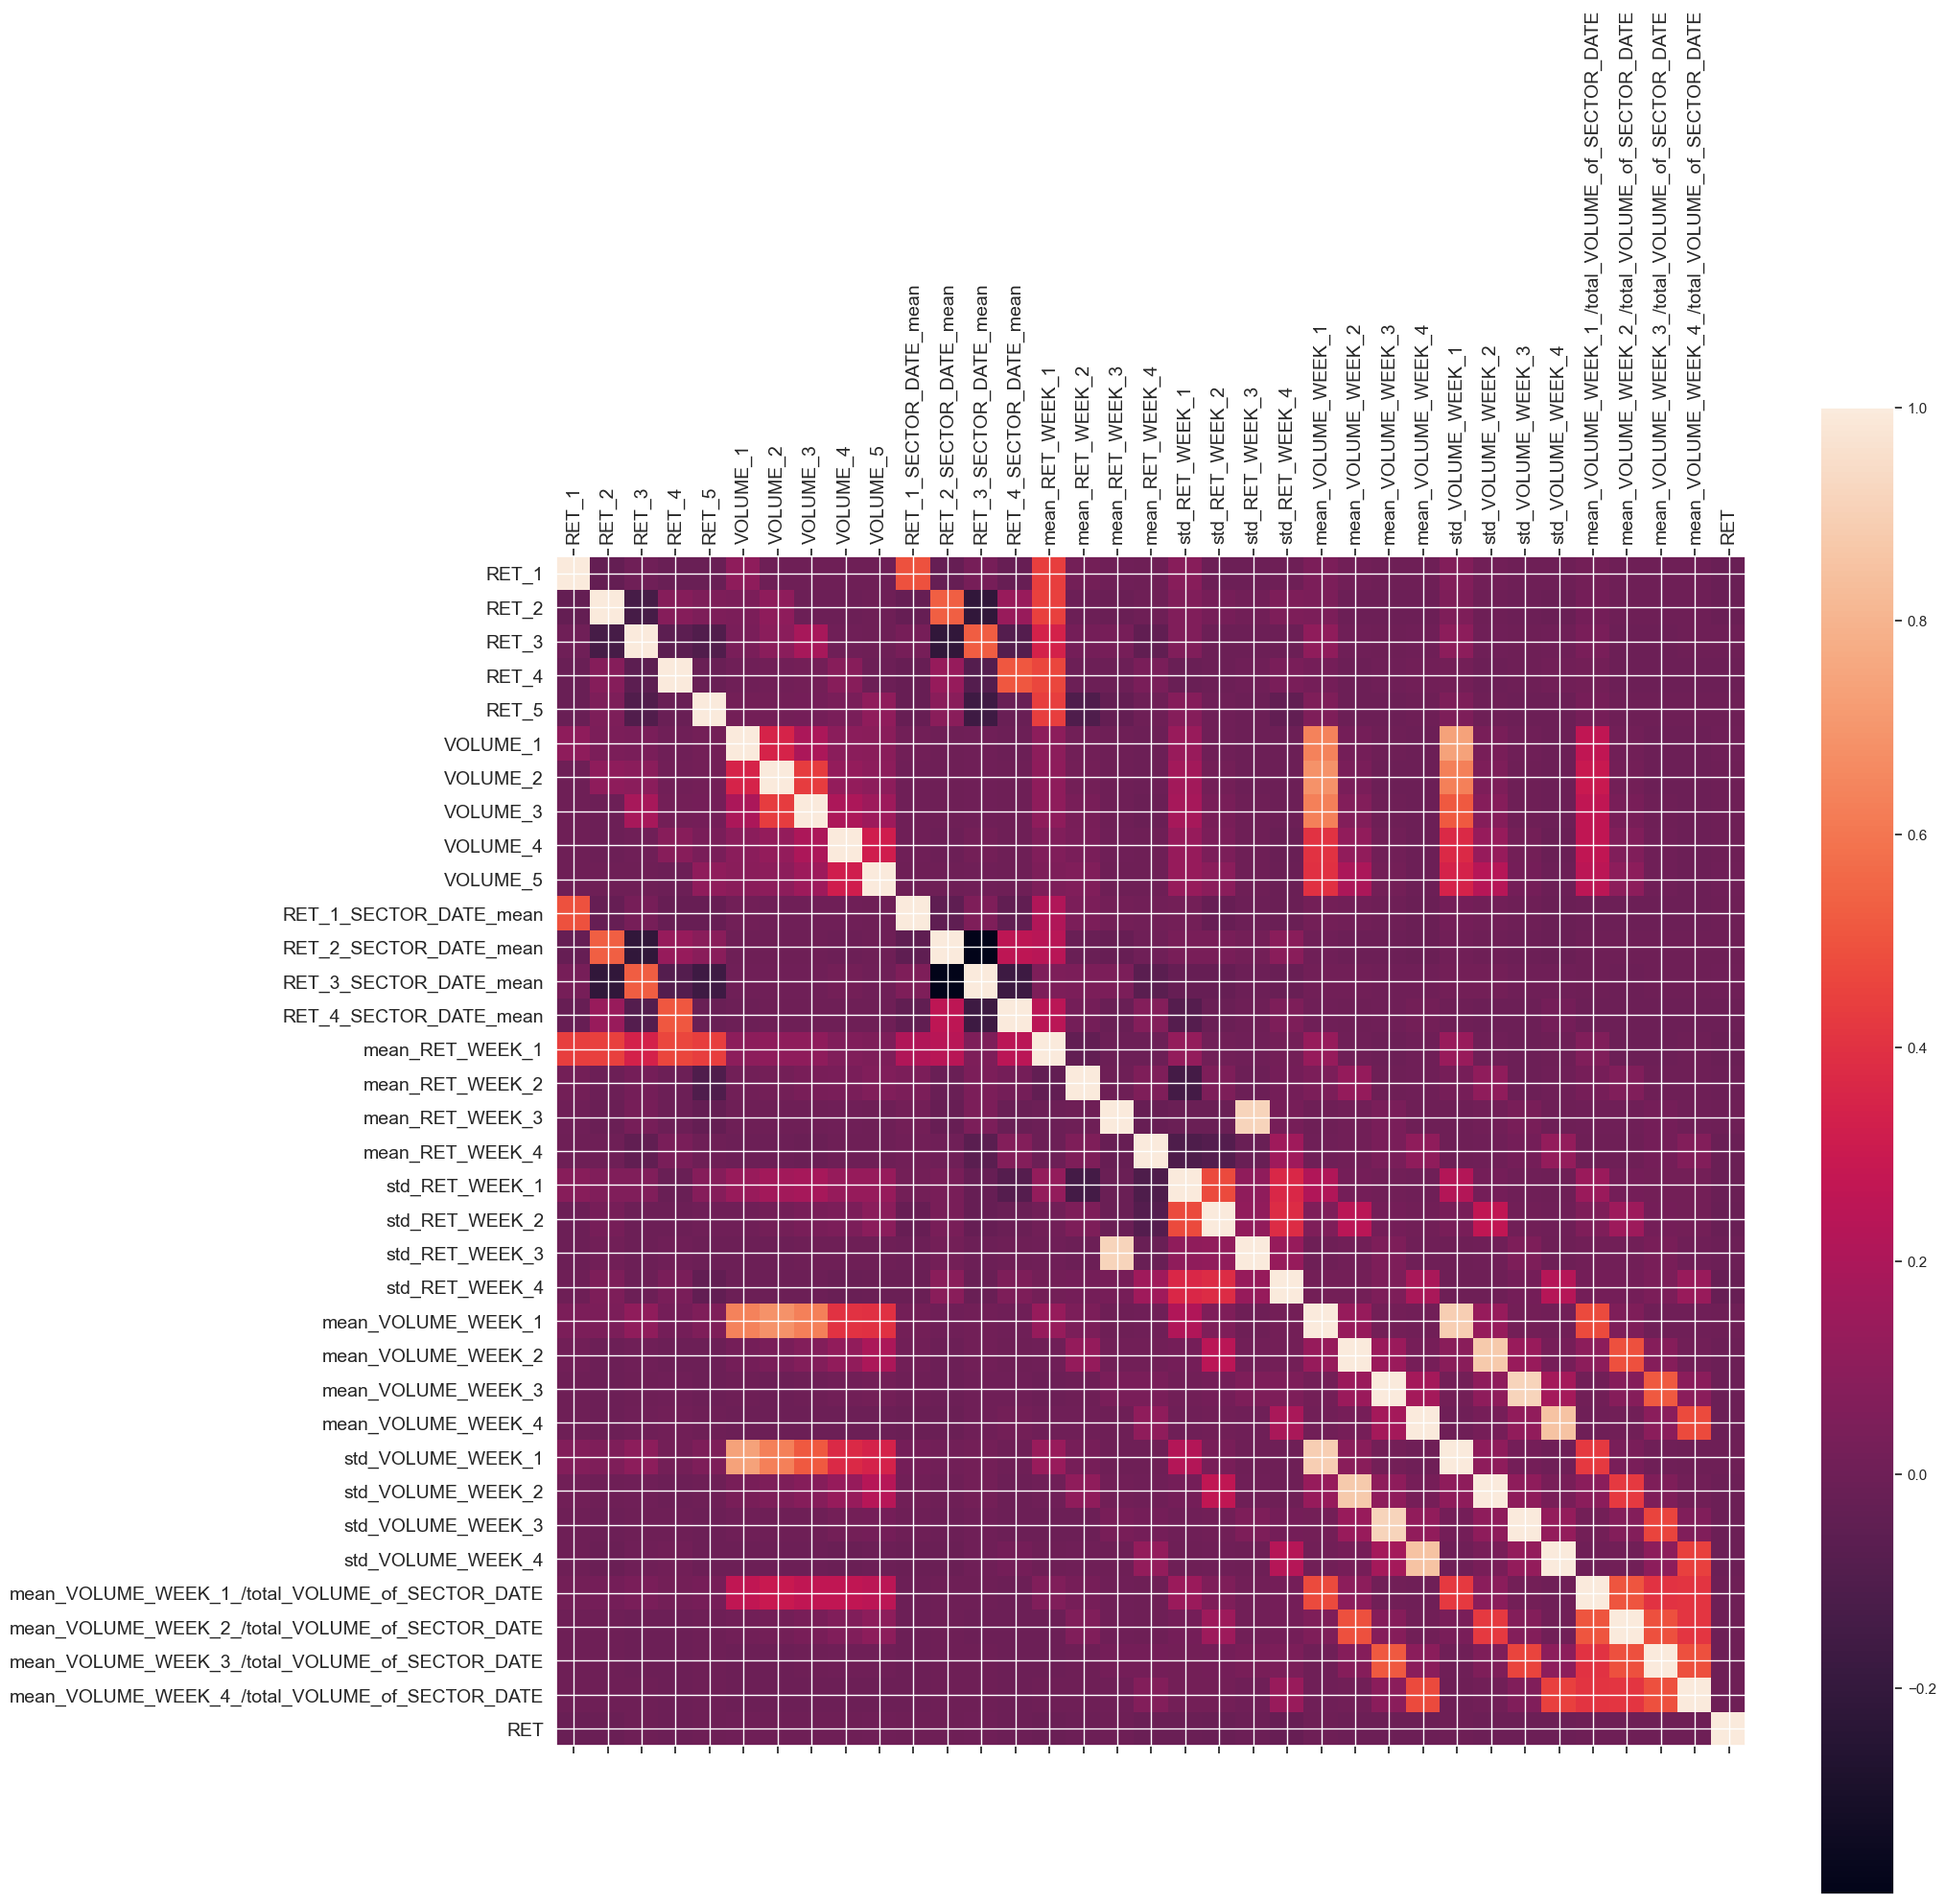

In [180]:
corr_features = features + ['RET']
fig = plt.figure(figsize=(20,20))
plt.matshow(train[corr_features].corr(), fignum=fig.number)
plt.xticks(range(train[corr_features].shape[1]), train[corr_features].columns, rotation=90, fontsize=14)
plt.yticks(range(train[corr_features].shape[1]), train[corr_features].columns, fontsize=14)
plt.colorbar()
plt.show()

# Model Selection and Local Score

In [329]:
X_train = train[features]
y_train = train[target]
# A quiet large number of trees with low depth to prevent overfits
parameters = {
    'boosting_type': 'rf',
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1, 
    #'feature_fraction': 0.1,
    'feature_fraction': 0.1,
    'objective': 'binary',
    'verbose': -1
}

rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}
train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []
models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates) # Generates the splits of the indexes to use as train / test

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    #model = LGBMClassifier(**parameters)
    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train.values.reshape(-1))

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = _Xtrain.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 52.54%
Fold 2 - Accuracy: 50.32%


<Axes: >

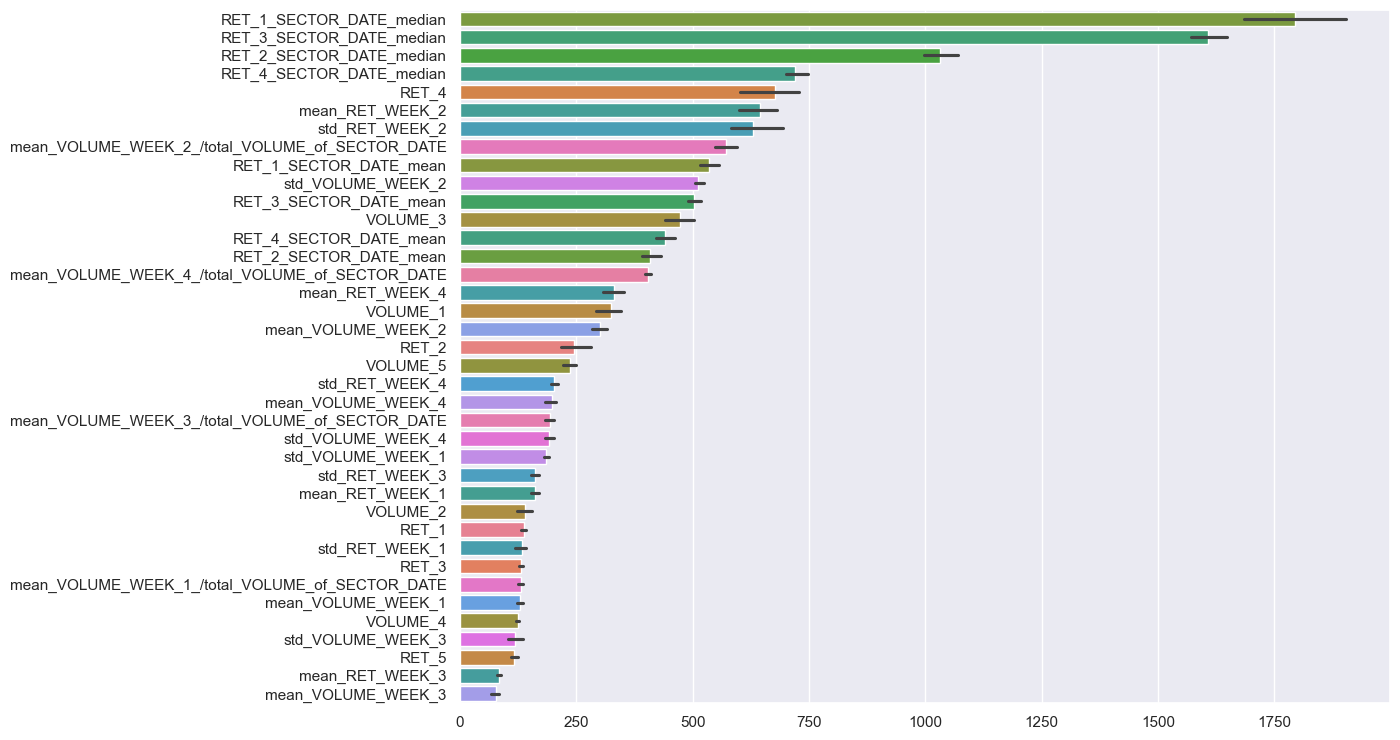

In [297]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

sns.set(rc={'figure.figsize':(12,9)})
sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)

# Prediction

In [191]:
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

target = 'RET'
y_train = train[target]
X_train = train[features]
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train, y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train)[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

y_pred = model.predict_proba(X_test)[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./y_test.csv', index=True, header=True)

0.5729237090744037


# Experiment Zone

We are now going to implement a version of a Bayesian Network. This means, we are going to create sequences of length 5 counting wheter the stock went up or down for each day.

In [82]:
for day in range(1,6):
    cleaned_train[f'y_bin_{day}'] = cleaned_train[f'RET_{day}'].transform(lambda x: 1 if x > 0 else 0)

In [83]:
cleaned_train

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_4,VOLUME_4,RET_5,VOLUME_5,RET,y_bin_1,y_bin_2,y_bin_3,y_bin_4,y_bin_5
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,-0.014672,-0.362868,0.016483,-0.972920,True,0,0,1,0,1
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,-0.025540,NaN,-0.038062,NaN,True,1,0,1,0,0
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,0.024852,-0.157421,0.009354,0.091455,False,1,0,0,1,1
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,-0.019677,-0.940163,0.003544,-0.882464,False,1,1,0,0,1
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,0.000000,-1.313896,0.022321,-1.204398,False,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418590,223,5703,32,10,4,77,0.021843,-0.217823,-0.021703,-0.125333,...,0.021379,-0.150397,0.001727,-0.026910,False,1,0,1,1,1
418591,223,5705,35,12,5,91,-0.006920,-0.375251,0.000000,-0.029437,...,0.009143,0.403533,0.009226,-0.840418,False,0,0,1,1,1
418592,223,5709,2,1,1,5,0.021869,-0.978856,-0.005929,-1.026267,...,0.006030,-0.784385,-0.015826,-0.701318,True,1,0,1,1,0


In [84]:
cleaned_train[[f'y_bin_{day}' for day in range(1,6)]]

,y_bin_1,y_bin_2,y_bin_3,y_bin_4,y_bin_5
ID,,,,,
0,0,0,1,0,1
1,1,0,1,0,0
2,1,0,0,1,1
3,1,1,0,0,1
4,1,0,0,0,1
...,...,...,...,...,...
418590,1,0,1,1,1
418591,0,0,1,1,1
418592,1,0,1,1,0


In [102]:
cleaned_train['sequences'] = list(zip(cleaned_train['y_bin_1'], cleaned_train['y_bin_2'], cleaned_train['y_bin_3']))
                                      #cleaned_train['y_bin_4'], cleaned_train['y_bin_5']))

In [103]:
cleaned_train['sequences'].value_counts()

sequences
(1, 0, 1)    58651
(0, 1, 0)    53741
(0, 1, 1)    52821
(1, 1, 1)    52470
(0, 0, 1)    51655
(1, 1, 0)    50997
(1, 0, 0)    50278
(0, 0, 0)    45726
Name: count, dtype: int64

In [97]:
16849/(12937+16849)

0.5656684348351575

# Balanc, statistics, feature engineering todo

In [273]:
###### didnt use that

shifts = [1,2,3,4]  # Choose some different shifts
statistics = ['sum']  # the type of stat
#gb_features_list = [['SECTOR', 'DATE'], ['INDUSTRY_GROUP', 'DATE']]
gb_features_list = [['SECTOR', 'DATE']]
target_features = ['mean_RET_WEEK', 'median_RET_WEEK']
for target_feature in target_features:
    for gb_features in gb_features_list:
        tmp_name = '_'.join(gb_features)
        for shift in shifts:
            for stat in statistics:
                name = f'{target_feature}_{shift}_/total_RET_of_SECTOR_DATE'
                feat = f'{target_feature}_{shift}'
                new_features.append(name)
                for data in [train, test]:
                    data[name] = data[feat]/data.groupby(gb_features)[feat].transform('sum')

In [50]:
X_test = test[features]

model = RandomForestClassifier(**rf_params)
model.fit(X_train.fillna(0), y_train)

sub = train.copy()
sub['pred'] = model.predict_proba(X_train.fillna(0))[:,1]
y_pred_train = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values
print(accuracy_score(y_pred_train,y_train))

0.5735448345059067
